### 🔧 Notebook Setup — Auto-Reload & Project Path

Before we start exploring different agent types and execution modes, we need to set up
our Jupyter environment so that it can import the Neurosurfer project cleanly and 
pick up code changes automatically.

### 📌 What this cell does

1. **Enables autoreload**  
   This makes Jupyter reload modules automatically whenever you modify the source code.  
   No need to restart the kernel each time you edit a Python file.

2. **Adds your project root to `sys.path`**  
   Your notebook likely lives inside a subfolder such as `b/` or `notebooks/`.  
   By moving one directory up and appending it to `sys.path`, Python can import your
   local Neurosurfer modules as if they were installed packages.


In [1]:
%load_ext autoreload
%autoreload 2

import sys, os

# Go up one directory from `b/` to project root
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

## 🤖 Initializing the Local LLM (Qwen3-8B-Unsloth)

This cell prepares the language model that all agents in this notebook will use.  
We load a locally stored Qwen3-8B model, quantized in 4-bit mode for efficient GPU usage.

### 🔧 What happens in this step
- **GPU memory is cleared** to avoid leftover allocations from earlier runs.
- **Model configuration parameters** are defined (model path, max sequence length, quantization mode, stop words, verbosity).
- **The TransformersModel wrapper is created**, which handles:
  - GPU/CPU device selection  
  - automatic dtype (bfloat16 on CUDA)
  - thread-safe generation
  - streaming support and stop-token detection
  - integration with all Neurosurfer agents

### 📌 Why this matters
All subsequent components — ReActAgent, CodeAgent, RAG workflows, and the Main Workflow —
reuse this single `LLM` instance.  
It ensures consistent generation behavior, reduced memory footprint, and faster warm-up.

### ⚙️ Key configuration highlights
- **model_name**: filesystem path to your local 4-bit Qwen3-8B model  
- **max_seq_length**: extended context window for longer agent chains  
- **load_in_4bit=True**: enables efficient inference on mid-range GPUs  
- **enable_thinking=False**: disables structured “thinking mode” tokens  
- **stop_words**: early-stop hints for streaming (e.g., “Observation:”)

After running this cell, the model is ready for use by all agents in the tutorial.


In [2]:
import logging
from neurosurfer.models.chat_models.transformers import TransformersModel
from neurosurfer import config 
import torch
torch.cuda.empty_cache()

DEFAULT_TRANSFORMERS_MODEL_PARAMS = dict({
    "model_name": "/home/nomi/workspace/Model_Weights/Qwen3-8B-unsloth-bnb-4bit",
    "max_seq_length": 12000,
    "load_in_4bit": True,
    "enable_thinking": False,  # main_gpu interpretation
    "verbose": False
})

LOGGER = logging.getLogger()
LLM = TransformersModel(
    **DEFAULT_TRANSFORMERS_MODEL_PARAMS,
    stop_words=["Observation:"],
    logger = logging.getLogger(),
)

╔══════════════════════════════════════════════════════════════════╗
║                                                                  ║
║ ▓▓▓▓▓   ▓▓▓▓                                  ▓▓▓                ║
║  ▓▓ ▓▓   ▓▓  ▓▓▓▓ ▓  ▓ ▓ ▓ ▓▓▓▓ ▓▓▓ ▓  ▓ ▓ ▓  ▓   ▓▓▓▓ ▓ ▓       ║
║  ▓▓  ▓▓  ▓▓  ▓▁▁▓ ▓  ▓ ▓▓▏ ▓  ▓ ▓▁  ▓  ▓ ▓▓▏ ▓▓▓  ▓▁▁▓ ▓▓        ║
║  ▓▓   ▓▓ ▓▓  ▓    ▓  ▓ ▓   ▓  ▓   ▓ ▓  ▓ ▓    ▓   ▓    ▓         ║
║ ▓▓▓▓   ▓▓▓▓▓ ▓▓▓▓ ▓▓▓▓ ▓   ▓▓▓▓ ▓▓▓ ▓▓▓▓ ▓    ▓   ▓▓▓▓ ▓         ║
║ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ║
║ Orchestrate Agents - RAG - SQL Tools - Multi-LLM - FastAPI Ready ║
║ Faster builds, clearer flows, production-first                   ║
║                                                                  ║
║ Version: 0.1.0 | Python: 3.12.12                                 ║
║ OS: Linux 6.17.0-7-generic (x86_64)                              ║
║ Torch: 2.8.0   CUDA: yes (12.8)                                  ║
║ MPS: no (built: False)          

/home/nomi/micromamba/envs/LLMs/lib/python3.12/importlib/__init__.py:90: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  return _bootstrap._gcd_import(name[level:], package, level)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
#### Unsloth: `hf_xet==1.1.10` and `ipykernel>6.30.1` breaks progress bars. Disabling for now in XET.
#### Unsloth: To re-enable progress bars, please downgrade to `ipykernel==6.30.1` or wait for a fix to
https://github.com/huggingface/xet-core/issues/526
Switching to PyTorch attention since your Xformers is broken.

Unsloth: Xformers does not work in RTX 50X, Blackwell GPUs as of yet. Please build from source via
```
pip install ninja
pip install -v --no-build-isolation -U git+https://github.com/facebookresearch/xformers.git@main#egg=xformers
```

🦥 Unsloth Zoo will now patch everything to make training faster!
INFO     | 2025-12-11 19:57:43 | transformers.py:init_model | Initializing Transformers model.
WARNING  | 2025-12-11 19:57:43 | transformers.py:init_model | Model is already quantized. Ignoring load_in_4bit=True.


`torch_dtype` is deprecated! Use `dtype` instead!


INFO     | 2025-12-11 19:57:44 | modeling.py:get_balanced_memory | We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO     | 2025-12-11 19:57:48 | transformers.py:init_model | Transformers model initialized successfully.


##### 📝 Streaming a Simple LLM Response

This cell demonstrates how to stream tokens directly from the model in real time.  
We send a system prompt and user message, enable `stream=True`, and print each token as it arrives.  
Streaming is useful for interactive agent outputs, debugging, and understanding how the model generates text step by step.


In [3]:
# streaming response example
from IPython.display import display, Markdown, clear_output

system_prompt = "You are a joker."
user_prompt = """Tell me a short and light-hearted joke."""

stream_response = LLM.ask(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    stream=True
)

md_display = display(Markdown(""), display_id=True)
for chunk in stream_response:
    chunk = chunk.choices[0].delta.content or ""
    print(chunk, flush=True, end="")

Why don't skeletons fight each other?  
Because they don't have the *guts*! 😄

## 🤖 Using the Generic Agent (LLM-Only Mode)

This section introduces the basic `Agent` class, which provides a lightweight wrapper around an LLM without invoking tools or complex workflows. It supports both normal (non-streaming) responses and streaming output.

### 🔧 What this cell demonstrates
- Creating an `Agent` with a simple configuration (temperature, token limit, streaming defaults).
- Sending a plain natural-language query and receiving a direct response.
- Showing how the agent integrates tracing, routing logic, and output handling behind the scenes.

### 📌 When to use this agent
Use the generic `Agent` whenever you want:
- a straightforward LLM response,
- optional structured JSON outputs,
- optional tool routing if a Toolkit is attached,
- lightweight experimentation without the full MainWorkflow.

This provides the foundation before moving on to more advanced agents like ReAct, CodeAgent, or RAGAgent.


In [4]:
# agent normal response
from neurosurfer.agents import Agent, AgentConfig
# from neurosurfer.tracing import RichTracer
from pydantic import BaseModel

agent_config = AgentConfig(
    strict_tool_call=True,
    return_stream_by_default=True,
    temperature=0.7,
    max_new_tokens=4096,
)
agent = Agent(llm=LLM, config=agent_config, log_traces=True)

# normal response
print("Normal Response:")
agent_response = agent.run(user_prompt="What is AI (one line)?", stream=False)
# print(agent_response.response)

# # streaming response
# print("\n\nStreaming Response:")
# for c in agent.run(user_prompt="What are top 3 applications of AI (one line)?").response:
#     print(c, flush=True, end="")


Normal Response:
🧠 Thinking...

[main_agent] Tracing Start!
 ▶ [1][step.agent] agent_id='main_agent' label='agent.run'
     ▶ [2][step.llm.call] agent_id='main_agent' label='agent.free_text_call'
     ◀ [2][step.llm.call] agent_id='main_agent' label='agent.free_text_call' took 0.699s; error=False
 ◀ [1][step.agent] agent_id='main_agent' label='agent.run' took 0.701s; error=False
[main_agent] Tracing End!

Final response:
AI, or Artificial Intelligence, is the simulation of human intelligence in machines that are programmed to think, learn, and perform tasks typically requiring human cognition.


### 📦 Structured Responses with Pydantic Models

This example shows how the Agent can produce **validated, structured outputs** instead of free-form text. By providing a Pydantic schema, the Agent is prompted to return JSON that matches the required fields, and any malformed output is automatically repaired or retried.

### 🔧 What this cell demonstrates
- Defining custom Pydantic models to shape the LLM’s output.
- Asking the Agent a natural-language query while enforcing a specific schema.
- Receiving a clean `json_obj` back, already parsed and validated.

### 📌 Why structured responses matter
Structured outputs make downstream processing far easier — especially for:
- pipelines,
- UI rendering,
- database inserts,
- chaining multiple agents,
- or building tool-driven reasoning graphs.

This is one of the core benefits of Neurosurfer’s generic Agent abstraction.


In [5]:
# Structured Response examples
class AIApplication(BaseModel):
    title: str
    description: str

class AI(BaseModel):
    definition: str
    history: str
    modern_frameworks: str
    applications: list[AIApplication]

user_query = "What is AI and list 3 of its top application, and 3 concerns."
agent_response = agent.run(user_prompt=user_query, output_schema=AI)

print("\nStructured Response:")
print(agent_response.response.json_obj)  

WARNING  | 2025-12-11 19:57:58 | agent.py:run     | `output_schema` provided with `stream=True`; forcing non-streaming structured output.
🧠 Thinking...

[main_agent] Tracing Start!
 ▶ [1][step.agent] agent_id='main_agent' label='agent.run'
     ▶ [2][step.llm.call] agent_id='main_agent' label='agent.structured_call.first_pass'
     ◀ [2][step.llm.call] agent_id='main_agent' label='agent.structured_call.first_pass' took 4.580s; error=False
 ◀ [1][step.agent] agent_id='main_agent' label='agent.run' took 4.593s; error=False
[main_agent] Tracing End!


Structured Response:
{
  "definition": "Artificial Intelligence (AI) is the simulation of human intelligence processes by machines, especially computer systems. These processes include learning, reasoning, problem-solving, perception, and language understanding.",
  "history": "The concept of AI was first introduced in the 1950s, with the term 'artificial intelligence' coined by John McCarthy in 1956. Early developments focused on creating m

#### 🔍 Inspecting Agent Traces

Each agent call produces a detailed trace that captures how the model processed the request.  
By inspecting a specific trace step, you can see metadata such as timing, inputs, whether tools were used, and whether the step succeeded.

**🔧 What this cell demonstrates**
- Accessing `agent_response.traces.steps`
- Viewing the internal details of the `agent.run` execution step
- Understanding inputs (streaming, schema enforcement, toolkit availability)
- Checking timing (`duration_ms`) and success state (`ok=True`)


This becomes even more valuable once we begin chaining agents or using RAG and code-execution modes.


In [6]:
agent_response.traces.steps[1].model_dump()

{'step_id': 2,
 'kind': 'llm.call',
 'label': 'agent.structured_call.first_pass',
 'node_id': None,
 'agent_id': 'main_agent',
 'started_at': 1765468678.035991,
 'duration_ms': 4579,
 'inputs': {'schema': 'AI',
  'system_prompt_len': 52,
  'user_prompt_len': 61,
  'user_prompt': 'What is AI and list 3 of its top application, and 3 concerns.',
  'system_prompt': "You are a precise and rule-abiding assistant.  \nYour task is to produce only a single valid JSON object following the schema below.\n\nStructured Output Contract:\n- Output only JSON — no markdown, code fences, or explanations.  \n- JSON must be strictly valid (RFC 8259): use double quotes for all keys and string values.  \n- Do not include extra keys or any text outside the JSON object.  \n- All required fields must be present, even if empty.  \n- Arrays must contain at least one object when applicable.  \n- The JSON must be a single complete object (not pretty-printed, no trailing commas).  \n- Failure to comply with this st

### 🔧 Using Tools with the Generic Agent

This section shows how to extend an Agent with custom tools.  
We define a simple calculator tool, register it inside a Toolkit, and attach that Toolkit to the Agent.

### 🔧 What this cell demonstrates
- Creating a custom tool by subclassing `BaseTool`
- Defining tool inputs, outputs, and descriptions using `ToolSpec`
- Registering the tool inside a `Toolkit`
- Allowing the Agent to decide whether to answer directly or call a tool (`strict_tool_call=False`)
- Viewing full execution traces showing the router LLM selecting the tool and executing it

### 📌 Why this is useful
Tools allow Agents to go beyond text generation and perform real actions:
- mathematical operations  
- data processing  
- API queries  
- database lookups  
- code execution  
- any custom operation your application needs

This example demonstrates the full tool-calling pipeline:
1. The router LLM interprets the request.
2. It selects the calculator tool.
3. The tool executes and returns the result.
4. The Agent wraps the result in a clean `ToolCallResponse`.

This pattern is the foundation for building more advanced multi-tool assistants.

Additionally, using `agent_response.traces`, we can see the complete execution trace for the agent call — including routing, the selected tool, LLM inputs/outputs, and the tool’s final return value. It’s useful for debugging and understanding exactly how the agent reached its decision.


In [7]:
from neurosurfer.agents.agent import Agent
from neurosurfer.tools.toolkit import Toolkit
from neurosurfer.tools.tool_spec import ToolSpec, ToolParam, ToolReturn
from neurosurfer.tools.base_tool import BaseTool, ToolResponse

# Simple Calculator Tool
class CalculatorTool(BaseTool):
    spec = ToolSpec(
        name="calculator",
        description="Perform basic arithmetic operations such as addition, subtraction, multiplication, and division.",
        when_to_use="Use this tool when you need to perform basic arithmetic operations.",
        inputs=[
            ToolParam(name="num1", type="float", description="The first number.", required=True),
            ToolParam(name="num2", type="float", description="The second number.", required=True),
            ToolParam(name="operation", type="string", description="The operation to perform strictly one of ['add', 'subtract', 'multiply', 'divide'].", required=True)
        ],
        returns=ToolReturn(type="float", description="The result of the arithmetic operation.")
    )

    def __init__(self, final_answer: bool = False):
        self.final_answer = final_answer

    def __call__(self, num1: float, num2: float, operation: str, **kwargs) -> ToolResponse:
        if operation not in ["add", "subtract", "multiply", "divide"]:
            return ToolResponse(
                final_answer=False,
                results="Invalid operation. Supported operations are 'add', 'subtract', 'multiply', and 'divide'.",
                extras={}
            )
        
        if operation == "divide" and num2 == 0:
            return ToolResponse(
                final_answer=False,
                results="Division by zero is not allowed.",
                extras={}
            )
        try:
            num1 = float(num1)
            num2 = float(num2)
            if operation == "add":
                result = num1 + num2
            elif operation == "subtract":
                result = num1 - num2
            elif operation == "multiply":
                result = num1 * num2
            elif operation == "divide":
                result = num1 / num2
        except Exception as e:
            return ToolResponse(
                final_answer=False,
                results=f"An error occurred: {str(e)}",
                extras={}
            )
        
        return ToolResponse(
            final_answer=self.final_answer,
            results=float(result),
            extras={}
        )

calculator_tool = CalculatorTool()
toolkit = Toolkit(tools=[calculator_tool])

# print("Tool description:")
# print(calculator_tool.get_tool_description())
# print()

agent = Agent(llm=LLM, toolkit=toolkit)

print("Agent with choice between tools and plain text:")
agent_response = agent.run(user_prompt="What is 1 + 1?", strict_tool_call=False, stream=False)
print(agent_response.response)

# print("\n\nAgent with strict tool call:")
# agent_response = agent.run(user_prompt="What is one forth of a 100?", strict_tool_call=True)
# print(agent_response.response)

# for chunk in agent_response.response.returns:
#     print(chunk, end="", flush=True)


INFO     | 2025-12-11 19:58:13 | toolkit.py:register_tool | Registered tool: calculator
Agent with choice between tools and plain text:
🧠 Thinking...

[main_agent] Tracing Start!
 ▶ [1][step.agent] agent_id='main_agent' label='agent.run'
     ▶ [2][step.llm.call] agent_id='main_agent' label='agent.route_and_call.router_llm_call'


        INFO: Selected tool: calculator
        INFO: Raw inputs: {'num1': 1, 'num2': 1, 'operation': 'add'}
     ◀ [2][step.llm.call] agent_id='main_agent' label='agent.route_and_call.router_llm_call' took 0.721s; error=False
     ▶ [3][step.tool.execute] agent_id='main_agent' label='agent.route_and_call.tool_execute'
        INFO: Tool 'calculator' Tool Return: 2.0...
     ◀ [3][step.tool.execute] agent_id='main_agent' label='agent.route_and_call.tool_execute' took 0.002s; error=False
 ◀ [1][step.agent] agent_id='main_agent' label='agent.run' took 0.726s; error=False
[main_agent] Tracing End!

ToolCallResponse(selected_tool='calculator', inputs={'num1': 1.0, 'num2': 1.0, 'operation': 'add'}, returns='2.0', final=False, extras={})


In [11]:
# agent_response.traces.model_dump()

## 🤖 ReAct Agent with Multiple Tools

This section demonstrates how the ReActAgent combines *reasoning*, *tool usage*, and *final natural-language responses* in a multi-step workflow. We register both the calculator and city-info tools, configure the ReAct agent, and ask it to perform a multi-tool reasoning task.

### 🔧 What this cell demonstrates
- Initializing the ReAct agent with a toolkit containing multiple tools  
- Using the agent’s reasoning loop to:
  1. look up information via tools,
  2. perform intermediate calculations,
  3. then produce a final user-facing answer
- Inspecting the agent’s step-by-step reasoning through trace logs

### 🧭 Why the ReAct pattern matters
ReAct (Reason + Act) provides a powerful mechanism enabling the model to:
- think step-by-step,
- decide which tool to use and when,
- execute tools with structured inputs,
- incorporate the results into its next reasoning step,
- and finally delegate the output to the configured final-answer generator.

### 🌍 Language + Length control
The configuration in this example instructs the agent to:
- output the final answer in **Urdu**,  
- using a **detailed** explanation style.  

This showcases how ReAct can seamlessly combine:
tool execution → internal reasoning → controlled natural-language output.

### 📌 What you’ll see in the output
The trace log shows:
- the agent thinking about the task,
- selecting the correct tool,
- performing the arithmetic with the calculator,
- switching into final-answer mode,
- and producing a polished, human-readable result in Urdu.

This example completes the picture of a full ReAct loop with multi-tool support and controlled final messaging.



In [8]:
import json 
from typing import Dict, Any
from neurosurfer.tools import BaseTool, ToolSpec, ToolParam, ToolReturn, ToolResponse

# CityInfoTool
class CityInfoTool(BaseTool):
    """
    Simple read-only city info DB so the ReAct agent has something non-trivial to reason about.
    """
    spec = ToolSpec(
        name="city_info",
        description="Look up basic information about a city (population and timezone).",
        when_to_use="Use this tool when you need factual info about a city such as population or timezone.",
        inputs=[
            ToolParam(name="city", type="string", description="City name, e.g. 'Paris', 'Tokyo'.", required=True),
        ],
        returns=ToolReturn(type="string", description="A short JSON-formatted string with fields like population_millions and timezone."),
    )

    def __init__(self):
        # tiny in-memory DB
        self._db = {
            "paris": {
                "population_millions": 2.1,
                "timezone": "Europe/Paris",
            },
            "tokyo": {
                "population_millions": 13.9,
                "timezone": "Asia/Tokyo",
            },
            "dubai": {
                "population_millions": 3.6,
                "timezone": "Asia/Dubai",
            },
        }

    def __call__(self, city: str, **kwargs: Dict[str, Any]) -> ToolResponse:
        city_key = city.strip().lower()
        info = self._db.get(city_key)
        if not info:
            result = f'{{"city": "{city}", "error": "unknown city"}}'
        else:
            result = json.dumps({"city": city_key, **info})

        return ToolResponse(
            results=result,
            final_answer=False,  # ReAct can decide what to do next
            extras={},          # you can stash anything here into memory if you want
        )


calculator_tool = CalculatorTool()
city_info_tool = CityInfoTool()

toolkit = Toolkit(tools=[calculator_tool, city_info_tool])

INFO     | 2025-12-11 19:58:20 | toolkit.py:register_tool | Registered tool: calculator
INFO     | 2025-12-11 19:58:20 | toolkit.py:register_tool | Registered tool: city_info


In [9]:
from neurosurfer.agents.react.agent import ReActAgent, ReActConfig
from neurosurfer.models.chat_models.base import BaseChatModel


react_config = ReActConfig(
    mode="delegate_final",
    skip_special_tokens=True,
    max_new_tokens=4096,
    temperature=0.7,
    log_internal_thoughts=True,
    final_answer_language="Urdu",
    final_answer_length="detailed",
)

react_agent = ReActAgent(
    id="react_agent_main",
    llm=LLM,
    toolkit=toolkit,
    config=react_config,
    log_traces=True,
)

query = (
    "I'm deciding between visiting Paris or Tokyo. "
    "Use your tools to: "
    "1) look up the population of each city in millions, "
    "2) compute how many millions more people live in Tokyo than in Paris, "
    "3) then give me a final recommendation in natural language using that number."
)

res = react_agent.run(query=query, stream=False)


# # For streaming Response
# res = react_agent.run(query=query, stream=True)
# for chunk in res.response: 
#     # print(chunk, end="", flush=True)
#     pass

# traces
# trace_dict = res.traces.model_dump()

🧠 Thinking...

 Tracing Start!
 ▶ [1][step.react_agent] agent_id='react_agent_main' label='react_agent.run'
     ▶ [2][step.llm.call] agent_id='react_agent_main' label='react_agent.loop.reason_llm_call'
        Thought: I need to look up the population of Paris and Tokyo first. I'll start by retrieving the population information for Paris.
        Action: {
          "tool": "city_info",
          "inputs": {
            "city": "Paris"
          },
          "memory_keys": [],
          "final_answer": false
        }        
        [🔧] Tool Selected: city_info
         ▶ [3][step.tool.execute] agent_id='react_agent_main' label='react_agent.loop.tool_execute'
            INFO: [🔧] Executing Tool: city_info, Attempt: 0, [📤] Inputs: {'city': 'Paris'}...
            
            [🔧] Tool Result: {"city": "paris", "population_millions": 2.1, "timezone": "Europe/Paris"}...
         ◀ [3][step.tool.execute] agent_id='react_agent_main' label='react_agent.loop.tool_execute' took 0.004s; erro

## 🧪 CodeAgent — Python Execution via ReAct

This example shows how the `CodeAgent` can analyze a user request, plan the required steps, and then execute real Python code through the built-in `python_execute` tool. The task here is to generate synthetic Lorenz-attractor data and produce a 3D plot.

### 🔧 What this cell demonstrates
- Initializing the `CodeAgent` with analysis-first mode (`analysis_only`)
- Allowing the agent to think step-by-step before calling the Python execution tool
- Automatically generating Python code, running it, and retrieving the results
- Viewing the generated plot file in the working directory
- Inspecting detailed traces showing:
  - reasoning thoughts,
  - tool selection,
  - executed Python code,
  - generated artifacts,
  - and the final explanatory output

### 🧭 Why the CodeAgent is useful
The CodeAgent is designed for tasks that require:
- data analysis,
- mathematical simulations,
- plotting and visualization,
- execution of multi-step logic,
- or any workflow where Python code is needed.

It combines ReAct reasoning with safe, sandboxed code execution, making it ideal for scientific, analytical, or exploratory notebooks.

### 📌 Outcome
You will see:
- the generated Python code,
- the saved `lorenz_attractor_3d.png` plot,
- and a final descriptive summary of what the code produced.

This marks the transition from pure LLM reasoning into full programmatic capabilities within the agent framework.


Code Agent Cofig:
CodeAgentConfig(mode='analysis_only', temperature=0.7, max_new_tokens=4096, allow_input_pruning=True, repair_with_llm=True, retry=RetryPolicy(max_parse_retries=2, max_tool_errors=2, backoff_sec=0.8), skip_special_tokens=False, return_stream_by_default=False, log_internal_thoughts=True, return_internal_thoughts=False, final_answer_language='english', final_answer_length='detailed', final_answer_max_history_chars=12000, forced_memory_keys={'python_execute': ['python_last_result_summary', 'python_last_error']}, agent_name='CodeAgent', enable_post_processing=False, default_workdir='.', encourage_multistep_planning=True, default_return_raw=False)

INFO     | 2025-12-11 19:58:41 | toolkit.py:register_tool | Registered tool: python_execute
🧠 Thinking...

[CodeAgent] Tracing Start!
 ▶ [1][step.react_agent] agent_id='CodeAgent' label='react_agent.run'
     ▶ [2][step.llm.call] agent_id='CodeAgent' label='react_agent.loop.reason_llm_call'
        Thought: I need to generate syn

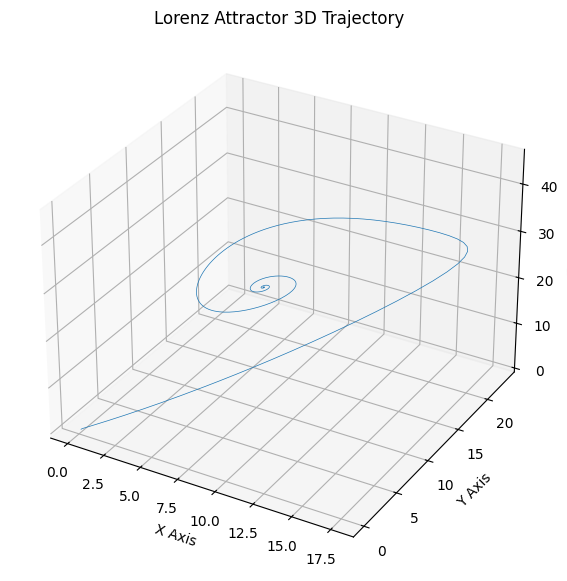

In [10]:
from neurosurfer.agents.code import CodeAgent, CodeAgentConfig

code_agent = CodeAgent(
    llm=LLM,
    config=CodeAgentConfig(
        mode="analysis_only",
        temperature=0.7,
        max_new_tokens=4096,
        log_internal_thoughts=True,
        default_workdir=".",
    ),
    log_traces=True,
)

user_query = """Generate a 3D plot of the Lorenz attractor using synthetic data with the classic (σ=10, ρ=28, β=8/3) parameters."""
agent_restuls = code_agent.run(query=user_query)

In [23]:
# print(agent_restuls.tool_calls[0].output)

## 📚 Retrieval-Augmented Generation (RAG) — Indexing & Querying a Document

This example demonstrates how to use the RAGAgent to ingest documents, build a searchable vector store, and answer queries using retrieved context. It showcases the full RAG pipeline: file reading → chunking → embedding → storage → retrieval → generation.

### 🔧 What this cell sets up
- A **Chunker** to split large documents into semantically meaningful segments.
- A **FileReader** capable of loading DOCX, PDF, text files, and more.
- A **SentenceTransformerEmbedder** to generate vector embeddings (`e5-small-v2`).
- A **RAGAgent** configured with:
  - persistent vector storage,
  - configurable retrieval depth,
  - deduplication,
  - multi-worker ingestion for speed.

### 📁 Ingesting a document
The agent reads the target file, chunks it, computes embeddings, and stores them on disk.  
A summary of ingestion statistics—chunk count, file size, processing time—is printed afterward.

### 🔍 Querying with RAG
We then pose a natural-language question and enable `stream=True` to visualize the answer as it’s generated.  
Under the hood, the RAGAgent:
1. retrieves the most relevant chunks,
2. injects them into the model as context,
3. produces a grounded, reference-aware answer.

### 📌 Why this matters
RAG is essential when working with:
- proprietary documents,
- long technical files,
- research papers,
- project documentation,
- meeting notes and knowledge bases.

This example demonstrates a complete retrieval-augmented workflow integrated directly with the Neurosurfer agent framework.


In [12]:
# scripts/index_repo_for_rag.py
from pathlib import Path
from neurosurfer.models.embedders.sentence_transformer import SentenceTransformerEmbedder
from neurosurfer.agents.rag.chunker import Chunker
from neurosurfer.agents.rag.filereader import FileReader
from neurosurfer.agents.rag import RAGAgent, RAGAgentConfig, RAGIngestorConfig

chunker = Chunker()
file_reader = FileReader()

embedder = SentenceTransformerEmbedder("intfloat/e5-small-v2")
rag_agent = RAGAgent(
    llm=LLM,
    embedder=embedder,
    file_reader=file_reader,
    chunker=chunker,
    config=RAGAgentConfig(
        top_k=5,
        fixed_max_new_tokens=2048,
        clear_collection_on_init=True,
        persist_directory="/home/nomi/rag-storage",
    ),
    ingestor_config=RAGIngestorConfig(
        batch_size=64,
        max_workers=4,
        deduplicate=True,
        normalize_embeddings=True,
        default_metadata=None,
        tmp_dir="/home/nomi/rag-storage",
    ),
)

dir_path = "./temp/AI Demonstration Proposal_Final_Draft.docx"
summary = rag_agent.ingest(sources=dir_path)

print("\nSummary of ingestion:")
for key, value in summary.items():
    print(f"{key}: {value}")
print()

# retrival_results = rag_agent.retrieve(user_query="Explain how graph agent is initialized", top_k=10)
# print("max_new_tokens", retrival_results.max_new_tokens)
# print()
# print(retrival_results.context)

INFO     | 2025-12-11 20:01:49 | SentenceTransformer.py:__init__ | Use pytorch device_name: cuda:0
INFO     | 2025-12-11 20:01:49 | sentence_transformer.py:__init__ | SentenceTransformer embedding model initialized.
WARNING  | 2025-12-11 20:01:49 | agent.py:__init__ | No vectorstore provided to RAGAgent, using default ChromaVectorStore. Initializing default collection `neurosurfer-rag-agent`
[Init] ChromaVectorStore initialized with collection: neurosurfer-rag-agent


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Summary of ingestion:
status: ok
sources: 1
chunks: 9
unique_chunks: 9
added: 9
finished_at: 1765468909.6063807
accepted_sources: 1
total_docs_in_collection: 9



In [13]:
# streaming response example
from IPython.display import display, Markdown, clear_output

user_query = """Explain MOM LLM Project in details."""
streaming_response = rag_agent.run(
    user_query, 
    retrieval_mode="smart", 
    stream=True
)

md_display = display(Markdown(""), display_id=True)
response = ""
for chunk in streaming_response:
    response += chunk.choices[0].delta.content or ""
    md_display.update(Markdown(response))

INFO     | 2025-12-11 20:01:54 | agent.py:retrieve | [RAGAgent.retrieve] Retrieval plan: RetrievalPlan(mode='smart', scope='wide', answer_breadth='single_fact', top_k=20, notes=None, extra=None)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     | 2025-12-11 20:01:54 | agent.py:retrieve | [RAGAgent.retrieve] Retrieved 9 documents
INFO     | 2025-12-11 20:01:54 | agent.py:retrieve | [RAGAgent.retrieve] Untrimmed context: 15423 chars
INFO     | 2025-12-11 20:01:54 | agent.py:retrieve | [RAGAgent.retrieve] Trimmed context: 15423 chars


The MOM LLM Project is an advanced AI initiative designed to automate the documentation of meetings through the integration of multimodal AI technologies. The project combines speech recognition and natural language understanding to transcribe audio recordings and generate comprehensive Minutes of Meeting (MOMs). Here is a detailed explanation of the project:

### 1. **Objective**
The primary objective of the MOM LLM Project is to automate the documentation of meetings by leveraging AI models to transcribe audio inputs and generate structured meeting minutes. This reduces the manual effort required for meeting documentation and enhances the accuracy of meeting reports.

### 2. **AI Workflow (Step-by-Step)**
- **Input Processing**: The system accepts either raw meeting text or audio files (MP3, WAV, M4A). Audio inputs are split into 30-second chunks and converted into log-Mel spectrograms for optimal model processing.
- **Audio Transcription**: The Whisper model performs Automatic Speech Recognition (ASR) with speaker diarization, producing timestamped transcripts with punctuation and speaker labels.
- **Content Analysis & Generation**: The transcribed text is processed by the Llama 3.1 8B Instruct model, which executes the following tasks:
  - Participant and role identification
  - Discussion summarization with contextual analysis
  - Action item extraction and assignment mapping
  - Decision documentation with rationale generation
- **Resource Optimization**: When system resources are limited, model quantization techniques (INT8/INT4) are applied to compress model weights, reducing memory usage from ~16GB to as low as ~2-4GB, while maintaining reliable performance for both CPU and GPU environments.

### 3. **Architecture Flow**
- **System Components**:
  - **Input Layer**: API Gateway (FastAPI) handles file uploads, validation, and authentication.
  - **Processing Pipeline**: Audio preprocessing, Whisper transcription, Llama inference with quantization, and structured output generation.
  - **Storage Layer**: Temporary audio storage, transcript cache, and MOM result repository.
  - **Response Layer**: RESTful endpoints returning structured outputs with meeting metadata and optional PDF export.
- **Data Flow Sequence**:
  - Client uploads audio or text input.
  - The system validates format and size (up to 1GB).
  - For audio input, Whisper transcribes speech into text; text input skips this stage.
  - Llama 8B Instruct analyzes content to extract participants, summary, and actions.
  - The system compiles results into a structured MOM format (participants, summary, key points, action items).
  - Output is returned as structured data, optionally exported as a formatted PDF.

### 4. **Model Specifications**
- **Whisper Model**: Used for audio transcription with speaker diarization.
- **Llama 3.1 8B Instruct**: Utilized for content analysis and structured output generation.
- **Quantization Techniques**: Applied for resource optimization, reducing memory usage and enabling deployment on varied computational environments.

### 5. **Benefits**
- **Scalability**: The system is designed to handle varied computational environments, ensuring performance on limited hardware resources.
- **Cost Efficiency**: The use of quantization and efficient model processing reduces computational costs.
- **Accuracy**: The integration of advanced AI models ensures high accuracy in meeting documentation.
- **Real-Time Intelligence**: The system provides real-time meeting intelligence and documentation, enhancing productivity and decision-making.

### 6. **Demo Deliverables**
- **AI-driven MOM generator**: Supports both text and audio inputs for meeting documentation.
- **Transcription dashboard**: Provides diarization logs and transcription details.
- **Configurable quantization**: Enables low-resource environments for deployment.
- **Structured MOM export**: Offers outputs in JSON and PDF formats for easy sharing and archiving.

### 7. **Summary**
The MOM LLM Project demonstrates a powerful application of multimodal AI, combining speech recognition and language understanding to automate meeting documentation. By integrating Whisper ASR for transcription and Llama 3.1 8B Instruct for structured output generation, it offers a scalable, cost-efficient, and accurate solution for real-time meeting intelligence and enterprise documentation.

## 🧩 GraphAgent — Multi-Node Workflow with Web Search, Outlining, Drafting, and Review

This section demonstrates how to use the `GraphAgent` to run a complete multi-stage writing workflow.  
A YAML graph defines the nodes (“research”, “outline”, “draft”, “review”), their tool access, dependencies, and output modes.  
The agent then orchestrates all nodes in sequence using the same LLM, Toolkit, and tracing system.

---

### 🔧 What this cell sets up
- **WebSearchTool** configured with SerpAPI and optional crawling.
- A **Toolkit** containing web search, enabling the research node to gather external information.
- A **GraphAgent** configured with:
  - a YAML workflow (`blog_workflow.yml`),
  - per-node policies (temperature, max tokens, structured/text modes),
  - a manager LLM that composes prompts and coordinates all nodes,
  - full tracing for transparency.

---

### 🧭 What happens during execution
The workflow runs node-by-node:

1. **research**  
   - Uses the web search tool to gather key information.  
   - Produces a structured summary exported as JSON.

2. **outline**  
   - Reads the research output.  
   - Generates a structured blog outline in markdown.  
   - Exported as an `.md` file.

3. **draft**  
   - Consumes both the outline and research data.  
   - Produces a long-form article draft (~3000 words).  
   - Exported as markdown.

4. **review**  
   - Reads the draft + research.  
   - Produces a structured technical/editorial review.  
   - Exported as markdown.

The manager LLM composes prompts for each node, ensuring that every tool, dependency, and policy is correctly applied.

---

### 📝 Why GraphAgent is powerful
- It allows you to define entire multi-step, multi-agent workflows declaratively via YAML.  
- Each node can have different modes: free-text, structured, tool-enabled, or special policies.  
- Tools are selectively available only to nodes that require them.  
- Every step is traced, logged, and exportable for inspection or reuse.  
- Output artifacts (research, outline, draft, review) are automatically saved to the `exports/` folder.

---

### 📌 What you see in the console
- Detailed traces for each node  
- Web search execution logs  
- LLM calls and tool routing decisions  
- Final responses for each stage  
- Automatic export notifications

This example showcases how to build full production-grade, multi-agent pipelines using Neurosurfer’s GraphAgent system.


### YAML Flow

In [ ]:
# test web search tool
from neurosurfer.tools.websearch import WebSearchTool, WebSearchConfig
from neurosurfer.tools.toolkit import Toolkit

api_key = os.getenv("SERPAPI_KEY", "API Key not found...")
print("API Key: ", f"{api_key[:8]}...")

web_search_tool = WebSearchTool(
    config=WebSearchConfig(
        engine="serpapi",
        engine_kwargs={"api_key": api_key},
        max_results=3,
        enable_crawl=True,
        max_crawl_results=2,
        content_words_limit=2000,
        content_limit_strategy="distributive",
        summarize=False,
        top_k=10,
    ),
    llm=LLM,
)

toolkit = Toolkit(tools=[web_search_tool])
print(toolkit.registry)

API Key:  f443633b...
WARNING  | 2025-12-11 20:11:44 | agent.py:__init__ | No vectorstore provided to RAGAgent, using default ChromaVectorStore. Initializing default collection `neurosurfer-rag-agent`
[Init] ChromaVectorStore initialized with collection: neurosurfer-rag-agent
INFO     | 2025-12-11 20:11:46 | SentenceTransformer.py:__init__ | Use pytorch device_name: cuda:0
INFO     | 2025-12-11 20:11:46 | sentence_transformer.py:__init__ | SentenceTransformer embedding model initialized.
INFO     | 2025-12-11 20:11:46 | toolkit.py:register_tool | Registered tool: web_search
{'web_search': <neurosurfer.tools.websearch.tool.WebSearchTool object at 0x77503639f5f0>}


In [16]:
from neurosurfer.models.chat_models.base import BaseChatModel
from neurosurfer.agents.graph import GraphAgent, ManagerConfig

graph_agent = GraphAgent(
    llm=LLM,
    graph_yaml="blog_workflow.yml",
    toolkit=toolkit,
    manager_config=ManagerConfig(
        temperature=0.5,
        max_new_tokens=4096,
    ),
    manager_llm=LLM,
    log_traces=True
)

# Run workflow
# graph_inputs = {
#     "topic_title": "The Missing Middle Layer: Why LLM Systems Need Tool Routers, Not Bigger Models",
#     "query": "Compose a 1000-1500 word blog on why tool-routing layers matter more than scaling LLM size, covering practical design patterns, examples, and tradeoffs.",
#     "audience": "Intermediate ML engineers",
#     "tone": "Practical and slightly opinionated",
# }

graph_inputs = {
    "topic_title": "Stop Treating LLMs as Black Boxes: The Case for Observability-First AI Systems",
    "query": "Compose a 1000-1500 word blog arguing why observability layers are essential in modern LLM systems, including tracing, metrics, feedback loops, and common failure patterns.",
    "audience": "Intermediate ML engineers",
    "tone": "Practical and slightly opinionated",
}

results = graph_agent.run(inputs=graph_inputs)
# result = await run_async(executor.run(inputs=graph_inputs))


INFO     | 2025-12-11 21:14:38 | toolkit.py:register_tool | Registered tool: web_search

[manager] Tracing Start!
 ▶ [1][step.llm.call] agent_id='manager' label='manager.compose_user_prompt'
 ◀ [1][step.llm.call] agent_id='manager' label='manager.compose_user_prompt' took 2.441s; error=False
[manager] Tracing End!

🧠 Thinking...

[research] Tracing Start!
 ▶ [1][step.agent] agent_id='research' label='agent.run'
     ▶ [2][step.llm.call] agent_id='research' label='agent.route_and_call.router_llm_call'
        INFO: Selected tool: web_search
        INFO: Raw inputs: {'query': 'Stop Treating LMs as Black Boxes: The Case for Observability-First AI Systems', 'hl': 'en'}
     ◀ [2][step.llm.call] agent_id='research' label='agent.route_and_call.router_llm_call' took 0.945s; error=False
     ▶ [3][step.tool.execute] agent_id='research' label='agent.route_and_call.tool_execute'
WARNING  | 2025-12-11 21:14:48 | ingestor.py:ingest | Some sources were skipped as unsupported: [None, None]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     | 2025-12-11 21:14:48 | agent.py:retrieve | [RAGAgent.retrieve] Retrieval plan: RetrievalPlan(mode='classic', scope=None, answer_breadth=None, top_k=10, notes=None, extra=None)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     | 2025-12-11 21:14:48 | agent.py:retrieve | [RAGAgent.retrieve] Retrieved 10 documents
INFO     | 2025-12-11 21:14:48 | agent.py:retrieve | [RAGAgent.retrieve] Untrimmed context: 10397 chars
INFO     | 2025-12-11 21:14:48 | agent.py:retrieve | [RAGAgent.retrieve] Trimmed context: 10397 chars
        INFO: Tool 'web_search' Tool Return: {'query': 'Compose a 1000-1500 word blog arguing why observability layers are essential in modern LL...
     ◀ [3][step.tool.execute] agent_id='research' label='agent.route_and_call.tool_execute' took 6.204s; error=False
 ◀ [1][step.agent] agent_id='research' label='agent.run' took 7.151s; error=False
[research] Tracing End!


[manager] Tracing Start!
 ▶ [2][step.llm.call] agent_id='manager' label='manager.compose_user_prompt'
 ◀ [2][step.llm.call] agent_id='manager' label='manager.compose_user_prompt' took 3.151s; error=False
[manager] Tracing End!

🧠 Thinking...

[outline] Tracing Start!
 ▶ [1][step.agent] agent_id='outline' label='agent.run'


In [22]:
results.model_dump()

{'graph': {'name': 'blog_workflow',
  'description': 'Example multi-agent workflow for writing and reviewing a technical blog using multiple specialized nodes (each node uses an Agent under the hood).\n',
  'inputs': [{'name': 'topic_title',
    'type': 'string',
    'required': True,
    'description': None},
   {'name': 'query', 'type': 'string', 'required': True, 'description': None},
   {'name': 'audience',
    'type': 'string',
    'required': True,
    'description': None},
   {'name': 'tone', 'type': 'string', 'required': True, 'description': None}],
  'nodes': [{'id': 'research',
    'description': None,
    'kind': 'base',
    'purpose': 'Perform focused research on the requested topic titled {topic_title}.',
    'goal': 'Collect key facts, terminology, and references that are directly useful for writing a technical blog post.',
    'expected_result': "A compact, structured summary with sections for 'key_points', 'sources', and 'risks_or_caveats'.",
    'tools': ['web_search']

## Docs Gen Agent

In [161]:
from neurosurfer_labs.tools.doc_gen.dir_scanning import DirectoryScanTool
from neurosurfer_labs.tools.doc_gen.code_symbol_index import CodeSymbolIndexTool
from neurosurfer.tools.toolkit import Toolkit

root_dir = "../neurosurfer"
dir_scan_tool = DirectoryScanTool()
code_index_tool = CodeSymbolIndexTool()

toolkit = Toolkit(tools=[dir_scan_tool, code_index_tool])

params = {
    "project_root": root_dir,
    "docs_root": "docs",
}

scan_results = dir_scan_tool(project_root=root_dir)
scan_results.results

INFO     | 2025-11-26 14:42:37 | toolkit.py:register_tool | Registered tool: directory_scan
INFO     | 2025-11-26 14:42:37 | toolkit.py:register_tool | Registered tool: code_symbol_index
INFO     | 2025-11-26 14:42:37 | dir_scanning.py:__call__ | DirectoryScanTool scanning project_root=/home/nomi/workspace/neurosurfer/neurosurfer docs_root=None max_depth=None


{'project_root': '/home/nomi/workspace/neurosurfer/neurosurfer',
 'docs_root': None,
 'python_files': [{'path': 'version.py',
   'abs_path': '/home/nomi/workspace/neurosurfer/neurosurfer/version.py',
   'module': 'neurosurfer.version',
   'package': 'neurosurfer'},
  {'path': 'config.py',
   'abs_path': '/home/nomi/workspace/neurosurfer/neurosurfer/config.py',
   'module': 'neurosurfer.config',
   'package': 'neurosurfer'},
  {'path': 'diagnostics.py',
   'abs_path': '/home/nomi/workspace/neurosurfer/neurosurfer/diagnostics.py',
   'module': 'neurosurfer.diagnostics',
   'package': 'neurosurfer'},
  {'path': 'logger.py',
   'abs_path': '/home/nomi/workspace/neurosurfer/neurosurfer/logger.py',
   'module': 'neurosurfer.logger',
   'package': 'neurosurfer'},
  {'path': '__init__.py',
   'abs_path': '/home/nomi/workspace/neurosurfer/neurosurfer/__init__.py',
   'module': 'neurosurfer.__init__',
   'package': 'neurosurfer'},
  {'path': 'db/__init__.py',
   'abs_path': '/home/nomi/workspace

In [162]:
python_files = scan_results.results["python_files"]
module_paths = None
code_index_results = code_index_tool(python_files=python_files, module_paths=module_paths)
code_index_results.results


{'modules': {'neurosurfer.version': {'path': 'version.py',
   'abs_path': '/home/nomi/workspace/neurosurfer/neurosurfer/version.py',
   'package': 'neurosurfer',
   'classes': [],
   'functions': []},
  'neurosurfer.config': {'path': 'config.py',
   'abs_path': '/home/nomi/workspace/neurosurfer/neurosurfer/config.py',
   'package': 'neurosurfer',
   'classes': [{'name': 'BaseModelConfig',
     'docstring': 'Base configuration shared across all model types.\n\nAll model configs inherit these common parameters.\nCan be extended with model-specific settings.',
     'methods': [{'name': 'to_dict',
       'docstring': 'Convert config to dictionary for unpacking into model __init__.\n\nArgs:\n    exclude_none: Exclude fields with None values\n    \nReturns:\n    Dictionary of configuration parameters',
       'args': ['self', 'exclude_none']}]},
    {'name': 'AppConfig',
     'docstring': 'General application configuration.\n\nManages application-level settings like versioning, networking,\n

In [163]:
from neurosurfer.models.chat_models.base import BaseChatModel
from neurosurfer.agents.graph import GraphAgent, ManagerConfig

graph_agent = GraphAgent(
    llm=LLM,
    graph_yaml="docgen_workflow.yml",
    toolkit=toolkit,
    manager_config=ManagerConfig(
        temperature=0.5,
        max_new_tokens=4096,
    ),
    manager_llm=LLM,
    log_traces=True
)

# Run workflow
graph_inputs = {
    "project_root": "/home/nomi/workspace/neurosurfer/neurosurfer",
    "docs_root": "/home/nomi/workspace/neurosurfer/docs",
    "include_patterns": ["neurosurfer.agents.*"],
    "exclude_patterns": [],
    "sections": [],
    "doc_template": "",
    "mode": "structured",
}
print(graph_agent)
results = graph_agent.run(inputs=graph_inputs)
# result = await run_async(executor.run(inputs=graph_inputs))

INFO     | 2025-11-26 14:42:44 | toolkit.py:register_tool | Registered tool: directory_scan

[manager] Tracing Start!
 ▶ [1][step.llm.call] agent_id='manager' label='manager.compose_user_prompt'
 ◀ [1][step.llm.call] agent_id='manager' label='manager.compose_user_prompt' took 1.904s; error=False
[manager] Tracing End!

🧠 Thinking...

[scan_repo] Tracing Start!
 ▶ [1][step.agent] agent_id='scan_repo' label='agent.run'
     ▶ [2][step.llm.call] agent_id='scan_repo' label='agent.route_and_call.router_llm_call'
        INFO: Selected tool: directory_scan
        INFO: Raw inputs: {'include_patterns': ['**'], 'exclude_patterns': [], 'max_depth': 10}
     ◀ [2][step.llm.call] agent_id='scan_repo' label='agent.route_and_call.router_llm_call' took 0.987s; error=False
     ▶ [3][step.tool.execute] agent_id='scan_repo' label='agent.route_and_call.tool_execute'
INFO     | 2025-11-26 14:42:47 | dir_scanning.py:__call__ | DirectoryScanTool scanning project_root=/home/nomi/workspace/neurosurfer/neur

In [ ]:
# from dataclasses import dataclass, field
# from typing import Generator, Optional, Union, List

# @dataclass
# class TraceResult:
#     steps: List[str] = field(default_factory=list)
#     def add(self, msg: str):
#         self.steps.append(msg)

# class DummyTracer:
#     def __init__(self):
#         self.results = TraceResult()
#     def trace(self, msg: str):
#         self.results.add(msg)

# @dataclass
# class AgentResponse:
#     response: Union[str, Generator[str, None, None]]
#     traces: Optional[TraceResult] = None

# class DummyAgent:
#     def __init__(self):
#         self.tracer = DummyTracer()

#     def run(self) -> AgentResponse:
#         def generator():
#             for i in range(3):
#                 msg = f"token_{i}"
#                 self.tracer.trace(f"TRACE: {msg}")   # tracing inside generator
#                 yield msg
#         return AgentResponse(
#             response=generator(),
#             traces=self.tracer.results  # shared reference
#         )

# agent = DummyAgent()
# res = agent.run()

# print("=== BEFORE iterating generator ===")
# print(res.traces.steps)   # should be empty

# print("\n=== DURING streaming ===")
# for tok in res.response:
#     print("yielded:", tok)
#     print("current traces:", res.traces.steps)

# print("\n=== AFTER streaming ===")
# print(res.traces.steps)   # should have all traces


=== BEFORE iterating generator ===
[]

=== DURING streaming ===
yielded: token_0
current traces: ['TRACE: token_0']
yielded: token_1
current traces: ['TRACE: token_0', 'TRACE: token_1']
yielded: token_2
current traces: ['TRACE: token_0', 'TRACE: token_1', 'TRACE: token_2']

=== AFTER streaming ===
['TRACE: token_0', 'TRACE: token_1', 'TRACE: token_2']


In [2]:
# import json
# print(results.final['plan_docs'].replace('```json', '').replace('```', ''))

In [13]:
results.nodes['scan_repo'].traces.model_dump()
# results.nodes['scan_repo'].traces

{'steps': [{'step_id': 1,
   'kind': 'agent',
   'label': 'agent.run',
   'node_id': None,
   'agent_id': 'scan_repo',
   'started_at': 1764051228.8918066,
   'duration_ms': 840,
   'inputs': {'agent_type': 'Agent',
    'has_toolkit': True,
    'structured': False,
    'stream': False,
    'strict_tool_call': False},
   'outputs': {},
   'meta': {},
   'ok': True,
   'error': None,
   'logs': []},
  {'step_id': 2,
   'kind': 'llm.call',
   'label': 'agent.route_and_call.router_llm_call',
   'node_id': None,
   'agent_id': 'scan_repo',
   'started_at': 1764051228.8921106,
   'duration_ms': 834,
   'inputs': {'attempt': 1,
    'strict_tool_call': False,
    'system_prompt_len': 1959,
    'user_prompt_len': 342,
    'user_prompt': 'Scan the project_root and docs_root to build a structured index of packages, modules, and existing markdown docs. Include all Python files and markdown documents, and organize them into a compact JSON object with the following keys: "packages", "modules", "pyth

In [57]:
print(results.nodes['scan_repo'].traces.steps[1].inputs['user_prompt'])

Scan the project_root and docs_root to build a structured index of packages, modules, and existing markdown docs. Focus on Python files and documentation in the specified directories, using the include_patterns and exclude_patterns provided. Output a compact JSON object with the keys "packages", "modules", "python_files", and "doc_files".


In [4]:
from __future__ import annotations
from typing import List, Optional
from pydantic import BaseModel, Field, field_validator
from dataclasses import dataclass, field
from typing import Dict

@dataclass
class RouterRetryPolicy:
    """Retry tuning for routing + tool execution."""
    max_route_retries: int = 2
    max_tool_retries: int = 1
    backoff_sec: float = 0.7  # linear backoff

@dataclass
class AgentConfig:
    """
    Top-level configuration for the Agent.
    """
    # Routing:
    allow_input_pruning: bool = True    # drop unknown inputs not in ToolSpec
    repair_with_llm: bool = True        # ask LLM to repair invalid routing/inputs
    strict_tool_call: bool = False      # router must output JSON; else can answer in plain text
    # synonyms: Dict[str, Dict[str, str]] = field(default_factory=dict)  # field -> {from: to}

    # LLM defaults:
    temperature: float = 0.7
    max_new_tokens: int = 512
    return_stream_by_default: bool = False

    # Retries:
    retry: RouterRetryPolicy = field(default_factory=RouterRetryPolicy)

    # Structured-output options:
    strict_json: bool = True                  # enforce RFC 8259 JSON
    max_repair_attempts: int = 1              # for malformed JSON repairs



class NodeBudget(BaseChatModel):
    """
    Budget / LLM-related overrides per node.

    These map directly to AgentConfig fields:
        - temperature      -> AgentConfig.temperature
        - max_new_tokens   -> AgentConfig.max_new_tokens
        - return_stream_by_default -> AgentConfig.return_stream_by_default
    """

    max_new_tokens: Optional[int] = Field(
        default=None,
        description="Override AgentConfig.max_new_tokens for this node only.",
    )
    temperature: Optional[float] = Field(
        default=None,
        description="Override AgentConfig.temperature for this node only.",
    )
    return_stream_by_default: Optional[bool] = Field(
        default=None,
        description="Override AgentConfig.return_stream_by_default for this node only.",
    )


class NodePolicy(BaseChatModel):
    """
    Per-node policy that can override some AgentConfig settings and add
    node-level execution constraints (e.g., timeout).

    YAML example:

        nodes:
          - id: research
            policy:
              retries: 1
              timeout_s: 30
              budget:
                max_new_tokens: 180
                temperature: 0.2
              allow_input_pruning: false
              repair_with_llm: true
              strict_tool_call: true
    """

    retries: Optional[int] = Field(
        default=None,
        description="Override AgentConfig.retry.max_route_retries for this node.",
    )
    timeout_s: Optional[int] = Field(
        default=None,
        description=(
            "Soft timeout for this node in seconds. Execution isn't forcibly "
            "cancelled but the node will be marked as errored if exceeded."
        ),
    )
    budget: Optional[NodeBudget] = None

    # Direct AgentConfig-like overrides
    allow_input_pruning: Optional[bool] = None
    repair_with_llm: Optional[bool] = None
    strict_tool_call: Optional[bool] = None
    strict_json: Optional[bool] = None
    max_repair_attempts: Optional[int] = None

    class Config:
        extra = "ignore"  # ignore unknown keys under 'policy'

c = AgentConfig()

p = NodePolicy(budget=NodeBudget(temperature=1.2))

print(c)
print(p)


NameError: name 'BaseChatModel' is not defined

### Python API version (no YAML)

In [9]:
import asyncio
from graph import Graph, Node, NodePolicy, GraphConfig, GraphExecutor
from neurosurfer.tools import Toolkit
from neurosurfer.models.chat_models.openai import OpenAIModel

# Reuse your existing toolkit + model
llm = LLM  # already created in your environment
tk = toolkit

graph = Graph(
    name="calc_and_explain",
    config=GraphConfig(max_concurrency=2),
    inputs_schema={"prompt": str},
    nodes=[
        Node(
            id="rewrite",
            fn="general_query_assistant",  # adjust name if needed
            inputs={
                # swap "query" -> "prompt" if your tool expects "prompt"
                "query": (
                    "You will receive a user request. Extract a SINGLE pure arithmetic expression that can be "
                    "evaluated by a calculator (e.g., '(42 * 7) - 5^2' or '0.035 * 12000').\n"
                    "- Do NOT include explanations.\n"
                    "- Return ONLY the expression as plain text.\n\n"
                    "User request:\n${inputs.prompt}"
                )
            },
            outputs=["num1", "num2", "operation"],
            policy=NodePolicy(
                retries=1,
                timeout_s=30,
                budget={"max_new_tokens": 128, "temperature": 0.1},
            ),
        ),
        Node(
            id="compute",
            fn="calculator",
            inputs={"num1": "${rewrite.num1}", "num2": "${rewrite.num2}", "operation": "${rewrite.operation}"},
            outputs=["text"],
            policy=NodePolicy(retries=0, timeout_s=15),
        ),
        Node(
            id="explain",
            fn="general_query_assistant",
            inputs={
                "query": (
                    "Original request: ${inputs.prompt}\n"
                    "Calculator result: ${compute.text}\n\n"
                    "Write a brief, user-friendly explanation of the result (one short paragraph)."
                )
            },
            outputs=["text"],
            policy=NodePolicy(
                retries=1,
                timeout_s=30,
                budget={"max_new_tokens": 180, "temperature": 0.2},
            ),
        ),
    ],
    outputs={"answer": "${explain.text}"},
)

executor = GraphExecutor(llm=llm, toolkit=tk, max_concurrency=2)

result = await run_async(
    executor.run(graph, inputs={"prompt": "Compute 3.5% of 12000 and explain"}, stream=True)
)

print("OK:", result.ok)
print("Answer:\n", result.outputs["answer"])


OK: True
Answer:
 The calculator result for your request is ${compute.text}. This means that after performing the calculation based on your input, the final answer is ${compute.text}. Let me know if you need further assistance!


### Planner-based path (using the YAML as a skeleton)

In [ ]:
import asyncio, tempfile, pathlib
from graph import PlannerAgent, FlowLoader, GraphExecutor

# 1) Write the YAML to a temp file (only for this demo)
yaml_text = r"""
name: calc_and_explain
inputs:
  prompt: str
config:
  max_concurrency: 2
nodes:
  - id: rewrite
    kind: task
    fn: general_query_assistant
    inputs:
      query: |
        You will receive a user request. Extract a SINGLE pure arithmetic expression that can be
        evaluated by a calculator (e.g., "(42 * 7) - 5^2" or "0.035 * 12000").
        - Do NOT include explanations.
        - Return ONLY the expression as plain text.

        User request:
        ${inputs.prompt}
    outputs: ["text"]
    policy: { retries: 1, timeout_s: 30, budget: { max_new_tokens: 128, temperature: 0.1 } }

  - id: compute
    kind: task
    fn: calculator
    inputs: { expression: ${rewrite.text} }
    outputs: ["text"]

  - id: explain
    kind: task
    fn: general_query_assistant
    inputs:
      query: |
        Original request: ${inputs.prompt}
        Calculator result: ${compute.text}

        Write a brief, user-friendly explanation of the result (one short paragraph).
    outputs: ["text"]
    policy: { retries: 1, timeout_s: 30, budget: { max_new_tokens: 180, temperature: 0.2 } }

outputs: { answer: ${explain.text} }
""".strip()

tmp = pathlib.Path(tempfile.gettempdir()) / "calc_and_explain.yml"
tmp.write_text(yaml_text)

# 2) Use the planner with a skeleton (so it returns your YAML-based Graph)
planner = PlannerAgent(llm=LLM)  # LLM not used when skeleton is set
graph = planner.plan_from_query(query="Compute 3.5% of 12000 and explain", skeleton=str(tmp))

# 3) Execute
executor = GraphExecutor(llm=LLM, toolkit=toolkit, max_concurrency=2)
result = asyncio.run(executor.run(graph, inputs={"prompt": "Compute 3.5% of 12000 and explain"}))

print("OK:", result.ok)
print(result.outputs["answer"])


Test ToolsRouterAgent

In [8]:
query = "Perform the calculation 20 * 90"

for chunk in tools_router_agent.run(query, temperature=0.7, max_new_tokens=4000):
    print(chunk, end="")


INFO     | 2025-11-06 11:08:32 | tools_router_agent.py:run | [router] Using tool: calculator
INFO     | 2025-11-06 11:08:32 | tools_router_agent.py:run | [router] Raw inputs: {'num1': 20.0, 'num2': 90.0, 'operation': 'multiply'}
1800.0

In [9]:
query = "Tell me a light-hearted joke!"

for chunk in tools_router_agent.run(query, temperature=0.7, max_new_tokens=4000):
    print(chunk, end="")

INFO     | 2025-11-06 11:08:33 | tools_router_agent.py:run | [router] Using tool: general_query_assistant
INFO     | 2025-11-06 11:08:33 | tools_router_agent.py:run | [router] Raw inputs: {'query': 'Tell me a light-hearted joke!'}
Why don't skeletons fight each other? They don't have the guts!None

## ReactAgent

In [21]:
from neurosurfer.agents.react import ReActAgent, ReActConfig

react_agent = ReActAgent(
    toolkit=toolkit,
    llm=LLM,
    specific_instructions="Always be concise in your answers. Break the task into steps if needed.",
    config=ReActConfig(
        temperature=0.7,
        max_new_tokens=4096,
        allow_input_pruning=True,
        repair_with_llm=True,
        skip_special_tokens=True,
        verbose=True
    )
)

# print(react_agent._system_prompt())
TASK = """Calculate 300 - 300. Then tell me a light-hearted joke about that result."""

for chunk in react_agent.run(TASK):
    print(chunk, end="")




[🧠] Chain of Thoughts...
Thought: I will first calculate 300 - 300 using the calculator tool, and then I will use the general_query_assistant tool to find a light-hearted joke about the result.

Action: {
  "tool": "calculator",
  "inputs": {
    "num1": 300,
    "num2": 300,
    "operation": "subtract"
  },
  "final_answer": false
}

[🔧] Tool: calculator
[📤] Inputs: {'num1': 300, 'num2': 300, 'operation': 'subtract'}

Observation:



[🧠] Chain of Thoughts...
Thought: The result of the calculation is 0. Now, I will use the general_query_assistant tool to find a light-hearted joke about the result.

Action: {
  "tool": "general_query_assistant",
  "inputs": {
    "query": "Tell me a light-hearted joke about the number 0."
  },
  "final_answer": true
}

[🔧] Tool: general_query_assistant
[📤] Inputs: {'query': 'Tell me a light-hearted joke about the number 0.'}

Why did the number 0 break up with the number 8?  
Because it found someone more "8" (8) than a zero!

Observation: Why did the number 0 break up with the number 8?  
Because it found someone more "8" (8) than a zero!



[🧠] Chain of Thoughts...
Thought: The calculation result is 0, and the joke provided is ready. The final answer is complete.

Final Answer: The result of 300 - 300 is 0. Here's a light-hearted joke about it: Why did the number 0 break up with the number 8? Because it found someone more "8" (8) than a zero!